In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, CuDNNLSTM, RepeatVector, TimeDistributed, Flatten, Dropout, LSTM
from tensorflow.python.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.python.keras.callbacks import TensorBoard
# https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Spot price and all other variables have been combined to one dataframe. The dataframe is loaded from a pickle file. The different variables have values from vastly different ranges, so they need to be normalized. The dataset also needs to be framed as a supervised learning problem. Currently the model will use t-1 timestep to predict timestep t.

In [38]:
# read dataframe from file
combined_df = pd.read_pickle('combined_df.pickle')
values = combined_df.values
variables = values.shape[1] # 17 variables in total
labelenc = LabelEncoder()
values[:,variables-1] = labelenc.fit_transform(values[:,variables-1])
values = values.astype('float64')
scaler = MinMaxScaler(feature_range=(-1,1))
normvalues = scaler.fit_transform(values)

# transform data to a supervised learning problem
normdf = pd.DataFrame(data=normvalues)
columns, names = list(),list() #n_in = 1 n_out = 1
for i in range(1,0,-1): # timesteps as input =  1
    columns.append(normdf.shift(i))
    names += [(f"var{j+1}(t-{i})") for j in range(variables)] # create previous timestep a.k.a t-1 column for all the variables 
    
for i in range(0,1): # timesteps out a.k.a how many hours to predict = 1
    columns.append(normdf.shift(-i))
    if i == 0:
        names += [(f"var{j+1}(t)") for j in range(variables)]
    else:
        names += [(f"var{j+1}(t-{i})") for j in range(variables)] # create previous timestep a.k.a t-1 column for all the variables 
data = pd.concat(columns,axis=1)
data.columns = names
data.dropna(inplace=True) # t-1 columns have NaN row at index 0
data.drop(data.columns[[np.arange(variables+1,variables*2)]],axis=1,inplace=True) # drop all other future columns except the first, which is the spot price
all_values = data.values
training_range = 365*24*4 # 4 years of training data, 2 years of test
train = all_values[:training_range,:]
test = all_values[training_range:,:]

train_X, train_y = train[:,:-1], train[:,-1]
train_X = train_X.reshape((train_X.shape[0],1,train_X.shape[1]))
test_X, test_y = test[:,:-1], test[:,-1]
test_X = test_X.reshape((test_X.shape[0],1,test_X.shape[1]))

/home/joni/.local/lib/python3.6/site-packages/pandas/core/indexes/base.py:3968: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = getitem(key)


Read the best results from hyperparameter optimization script, create LSTM model and use best hyperparameters to train the model

In [48]:
hyperparam_df = pd.read_csv('model_result_1.csv')
hyperparam_df.sort_values(by='MAE',inplace=True)
hyperparam_df.reset_index(inplace=True)
print(hyperparam_df.head(3))
epochs,neurons,optimizer,learning_rate,batch_size = hyperparam_df.loc[0][['epochs','neurons','optimizer','learning_rate','batch_size']] # get the lowest MAE

   index  Unnamed: 0  epochs  neurons  \
0     56          56      20       80   
1     86          86      20       80   
2     81          81      20       60   

                                           optimizer  learning_rate  \
0  <class 'tensorflow.python.keras.optimizers.Adam'>         0.0005   
1  <class 'tensorflow.python.keras.optimizers.Adam'>         0.0001   
2  <class 'tensorflow.python.keras.optimizers.Adam'>         0.0001   

   batch_size      RMSE       MAE  
0          24  6.175898  3.608446  
1          24  6.173855  3.635865  
2          12  6.148628  3.650167  


In [42]:
model = Sequential()
model.add(CuDNNLSTM(200,input_shape=(train_X.shape[1],train_X.shape[2])))
model.add(Dense(1))
print(model.summary())
opt = Adam(lr=learning_rate)
model.compile(loss='mse',optimizer=opt)
tensorboard = TensorBoard(log_dir='./logs',histogram_freq=0,write_graph=True,write_images=False)
model.fit(train_X,
          train_y,
          epochs=epochs,
          batch_size=batch_size,
          verbose=1,
          validation_data=(test_X,test_y),
          shuffle=False,
          callbacks=[tensorboard])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_2 (CuDNNLSTM)     (None, 200)               175200    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 175,401
Trainable params: 175,401
Non-trainable params: 0
_________________________________________________________________
None
Train on 35040 samples, validate on 17542 samples
Epoch 1/20
35040/35040 [==============================] - 14s 413us/step - loss: 0.0093 - val_loss: 0.0154
Epoch 2/20
35040/35040 [==============================] - 7s 208us/step - loss: 0.0035 - val_loss: 0.0074
Epoch 3/20
35040/35040 [==============================] - 7s 208us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 4/20
35040/35040 [==============================] - 7s 206us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 5/20
35040/35040 [============================

Predict with model and convert the normalized prediction back to real value

In [44]:
# forecast
y_hat = model.predict(test_X)
test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
inverted_y_hat = np.concatenate((y_hat,test_X_reshaped[:,1:]),axis=1)
inverted_y_hat = scaler.inverse_transform(inverted_y_hat)
inverted_y_hat = inverted_y_hat[:,0]

# actual
test_y_reshaped = test_y.reshape((len(test_y),1))
inverted_y = np.concatenate((test_y_reshaped,test_X_reshaped[:,1:]), axis=1)
inverted_y = scaler.inverse_transform(inverted_y)
inverted_y = inverted_y[:,0]

# RMSE
rmse = np.sqrt(mean_squared_error(inverted_y,inverted_y_hat))
print(f"Test RMSE: {rmse}")

# MAE
mae = mean_absolute_error(inverted_y,inverted_y_hat)
print(f"Test MAE: {mae}")

Test RMSE: 6.380538849392746
Test MAE: 3.8751546950285545


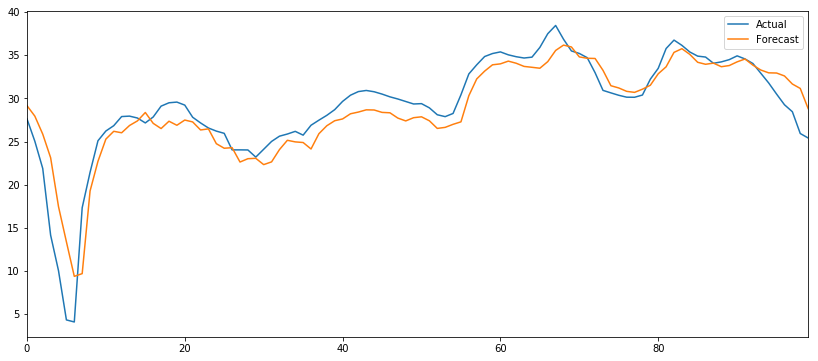

In [63]:
matplot_df = pd.DataFrame(columns=['Actual','Forecast'])
matplot_df['Actual'] = inverted_y
matplot_df['Forecast'] = inverted_y_hat
matplot_df[:100].plot(figsize=(14,6))